Katie Mears

# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [37]:
!pip install emoji

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
import os
import re
import emoji
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from string import punctuation
from nltk.corpus import stopwords
sw = stopwords.words("english")
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# change `data_location` to the location of the folder on your machine.
data_location = "/content/drive/MyDrive/M1 Results/"

# These subfolders should still work if you correctly stored the
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

In [60]:
 artist_files = {'cher':'cher_followers_data.txt',
 'robyn':'robynkonichiwa_followers_data.txt'}

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well.

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist.




In [42]:
# Initialize lists to store data
artists = []
songs = []
lyrics = []

# Set the path to the lyrics folder
lyrics_path = os.path.join(data_location, lyrics_folder)

# Iterate through each artist folder
for item in os.listdir(lyrics_path):
    if os.path.isdir(os.path.join(lyrics_path, item)):
        for lyric_page in os.listdir(os.path.join(lyrics_path, item)):
            # Split the filename to get artist and song names
            artist, song = lyric_page.split("_")
            song = song.replace(".txt", "")
            artists.append(artist)
            songs.append(song)

            # Open the lyric file
            try:
                with open(os.path.join(lyrics_path, item, lyric_page), 'r') as infile:
                    # Skip the title and blank lines
                    next(infile)  # skip title
                    next(infile)  # skip blank
                    next(infile)  # skip blank
                    next(infile)  # skip final blank

                    # Read the lyrics and store them
                    lyrics.append(infile.read())
            except Exception as e:
                # Handle any errors that occur while reading the file
                lyrics.append("")

# Create a DataFrame with the collected data
lyrics_data = pd.DataFrame({
    'artist': artists,
    'song': songs,
    'lyrics': lyrics
})

# Display the first few rows of the DataFrame to verify
print(lyrics_data.head())


  artist                    song  \
0   cher  youvemademesoveryhappy   
1   cher      stillinlovewithyou   
2   cher                  pirate   
3   cher                darklady   
4   cher            disastercake   

                                              lyrics  
0  I've lost at love before\nGot mad and closed t...  
1  Visions haunt my memory\nThey hold on, hold on...  
2  He'll sail on with the summer wind\nThat blows...  
3  The fortune queen of New Orleans\nWas brushing...  
4  If you're gonna make an omelette\nYou gotta br...  


In [43]:
# Read in the twitter data
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
  sep="\t",
 quoting=3)
twitter_data['artist'] = "cher"

In [44]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
 sep="\t",
 quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
  twitter_data,twitter_data_2])

del(twitter_data_2)

In [45]:
twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [46]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a
# dictionary for this.

# Define file paths
positive_words_path = os.path.join(data_location, positive_words_file)
negative_words_path = os.path.join(data_location, negative_words_file)
tidy_text_path = os.path.join(data_location, tidy_text_file)

# Read in positive words
with open(positive_words_path, 'r') as file:
    positive_words = [line.strip() for line in file if line.strip()]

# Read in negative words
with open(negative_words_path, 'r') as file:
    negative_words = [line.strip() for line in file if line.strip()]

# Create a dictionary to store words and their scores
sentiment_dict = {}
for word in positive_words:
    sentiment_dict[word] = 1  # +1 for positive words
for word in negative_words:
    sentiment_dict[word] = -1  # -1 for negative words

# Print the first few items in the sentiment dictionary for verification
print("Sentiment Dictionary Sample:")
for word, score in list(sentiment_dict.items())[:5]:  # Show the first 5 entries
    print(f"Word: {word}, Score: {score}")

Sentiment Dictionary Sample:
Word: ;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;, Score: 1
Word: ;, Score: -1
Word: ; Opinion Lexicon: Positive, Score: 1
Word: ; This file contains a list of POSITIVE opinion words (or sentiment words)., Score: 1
Word: ; This file and the papers can all be downloaded from, Score: -1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository.

After you have calculated these sentiments, answer the questions at the end of this section.


In [47]:
# your code here

def calculate_sentiment_score(lyrics):
    # Preprocess and tokenize the lyrics
    lyrics = lyrics.lower()  # Convert to lowercase
    tokens = lyrics.split()  # Split into words
    # Count sentiment scores
    score = sum(sentiment_dict.get(token, 0) for token in tokens)
    return score

# Apply the function to calculate sentiment scores
lyrics_data['sentiment_score'] = lyrics_data['lyrics'].apply(calculate_sentiment_score)

# Display the results
print(lyrics_data[['artist', 'lyrics', 'sentiment_score']])

    artist                                             lyrics  sentiment_score
0     cher  I've lost at love before\nGot mad and closed t...               14
1     cher  Visions haunt my memory\nThey hold on, hold on...               -1
2     cher  He'll sail on with the summer wind\nThat blows...               12
3     cher  The fortune queen of New Orleans\nWas brushing...               -5
4     cher  If you're gonna make an omelette\nYou gotta br...               -6
..     ...                                                ...              ...
415  robyn  I couldn't wait another minute when I had you ...                4
416  robyn  Isn't funny how some people never practice wha...               -5
417  robyn  Been alone in here forever\nWaiting in the dar...                0
418  robyn  Hey now boy, where you been?\nSmashed up toy, ...               -2
419  robyn  Mmmm... no I don't like that one\nNo I don't l...                3

[420 rows x 3 columns]


In [48]:
average_sentiment = lyrics_data.groupby('artist')['sentiment_score'].mean().reset_index()
print(average_sentiment)

  artist  sentiment_score
0   cher         3.079114
1  robyn         2.019231


# First Artist = Cher


In [49]:
first_artist = lyrics_data['artist'].iloc[0]
first_artist_songs = lyrics_data[lyrics_data['artist'] == first_artist]

# Get the three songs with the highest and lowest sentiment scores
top_songs = first_artist_songs.nlargest(3, 'sentiment_score')
bottom_songs = first_artist_songs.nsmallest(3, 'sentiment_score')
top_songs


,artist,song,lyrics,sentiment_score
115,cher,perfection,"Hush little Baby, gotta be strong\n'Cause in t...",41
139,cher,loveandunderstanding,"Here, here in this world\nWhere do we go? Wher...",41
19,cher,mylove,When I go away\nI know my heart can stay with ...,34


In [50]:
bottom_songs

,artist,song,lyrics,sentiment_score
195,cher,iwalkonguildedsplinters,"Some people think they jive me, but I know the...",-24
153,cher,outrageous,"Outrageous, outrageous\n(They say) I'm outrage...",-20
252,cher,dressedtokill,I slip into my shoes and slide into the night\...,-16


In [51]:
# Print the lyrics of those songs
print(f"Top 3 Songs by {first_artist} with Highest Sentiment:")
for index, row in top_songs.iterrows():
    print(f"Lyrics:\n{row['lyrics']}\nSentiment Score: {row['sentiment_score']}\n")

print(f"Bottom 3 Songs by {first_artist} with Lowest Sentiment:")
for index, row in bottom_songs.iterrows():
    print(f"Lyrics:\n{row['lyrics']}\nSentiment Score: {row['sentiment_score']}\n")

Top 3 Songs by cher with Highest Sentiment:
Lyrics:
Hush little Baby, gotta be strong
'Cause in this world we are born to fight
Be the best, prove them wrong
A winner's work is never done, reach the top, number one

Oh, perfection
You drive me crazy with perfection
I've worn my pride as my protection
Perfection, ohh

I was taught to be tough
That the best that you can be ain't enough
Crack the whip, sacrifice
But I found out paradise had a price

I didn't know it then, but oh I know it now
You gotta work as hard as love to make the love work out
You know this heart of mine has made some big mistakes
I guess that when it comes to love, I just don't know what I takes

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right
Nothing's perfect when the love ain't right

Gave it all, played my part
I gave everything I had but my heart
Worked so hard, made a name
But the loneliness in

# Second Atrist = Robyn

In [52]:
second_artist = lyrics_data['artist'].unique()[1]
second_artist_songs = lyrics_data[lyrics_data['artist'] == second_artist]

# Get the three songs with the highest and lowest sentiment scores
top_songs2 = second_artist_songs.nlargest(3, 'sentiment_score')
bottom_songs2 = second_artist_songs.nsmallest(4, 'sentiment_score')
top_songs2

,artist,song,lyrics,sentiment_score
342,robyn,loveisfree,"Free\nLove is free, baby\nFree\nLove is free, ...",91
379,robyn,indestructible,I'm going backwards through time at the speed ...,26
374,robyn,ushouldknowbetter114529,I've gone around the world and the seven seas\...,25


In [53]:
bottom_songs2

,artist,song,lyrics,sentiment_score
371,robyn,dontfuckingtellmewhattodo114520,My drinking is killing me\nMy drinking is kill...,-76
388,robyn,dontfuckingtellmewhattodo,My drinking is killing me\nMy drinking is kill...,-76
320,robyn,criminalintent,"Somebody alert the authorities, I got criminal...",-54
412,robyn,crashandburngirl,I should write a song about you and all the sh...,-22


In [54]:
highest_sentiment_songs = second_artist_songs.nlargest(3, 'sentiment_score')
lowest_sentiment_songs = second_artist_songs.nsmallest(4, 'sentiment_score')

# Print the lyrics of those songs
print("\nTop 3 Songs with Highest Sentiment:")
for _, row in highest_sentiment_songs.iterrows():
    print(f"Song: {row['song']}\nSentiment Score: {row['sentiment_score']}\nLyrics:\n{row['lyrics']}\n")

# Print the lyrics of the lowest sentiment songs
print("\nTop 4 Songs with Lowest Sentiment:")
for _, row in lowest_sentiment_songs.iterrows():
    print(f"Song: {row['song']}\nSentiment Score: {row['sentiment_score']}\nLyrics:\n{row['lyrics']}\n")


Top 3 Songs with Highest Sentiment:
Song: loveisfree
Sentiment Score: 91
Lyrics:
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give

### Questions

Q: Overall, which artist has the higher average sentiment per song?

A: According to the average sentiment score calculation, Cher had the higher average sentiment score per song.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: The top 3 are Perfection, Love and Understanding, and My Love. Two songs were tied for the highest sentiment score (41), Perfection, and Love and Understanding. Perfection has a lot of the positive sentiment words, and repeats words like perfect, perfection and love several times throughout the lyrics, it also has words like pride and protection which appear on the positive sentiment words list. Love and Understanding, has the words love and enough, which seem to boost the sentiment score for this song. The song with the third highest score (34) called My Love, had the word Love many times throughout the song. I think this is the largest contributor to the sentiment score.

The bottom 3 songs are I walk on guilded splinters, outrageous and dressed to kill. I walk on guilded splinters had the lowest score (-24), and contained words like poison, enemies, fire, burn, and needles which seem to contribut to it being the least sentimental. The song outrageous had a sentiment score of -20, contained the word outrageous many times, as well as rage that seem to have driven the low score for sentiment in this song. And third, dressed to kill with a -16 sentiment score has words like kill, blood, dark, and fall which may have contributed to its lower score.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: For the first some, Love is free, which had a sentiment score of 91, words like free, love and baby are repeated several times throughout the song which seem to have contributed to the high score. The next song, Indestructable which had a score of 26, it has positive words like love, and heart mentioned throughout the song, which likly contributed to the second highest sentiment score. The last song, u should know better, had a sore of 25, this song repeats the word better several times throughout the lyrics which probably played a large role in the sentiment score. On the other hand, the negative sentiment songs, were much more negative than Cher's were. The song Don't f###ing tell me what to do, uses the word killing on almost every line of the song, as well as some explicit language at the end which likely contributed to this being the largest negative score on the list. Secondly, criminal intent uses words like criminal, conspiracy, indecent, and lewd which play into the negative sentiment of this song. And last, the song called crash and burn girl, states the words, crash and burn, idiot, crying, and smashing which all seems to be playing into the negative sentiment of this song.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




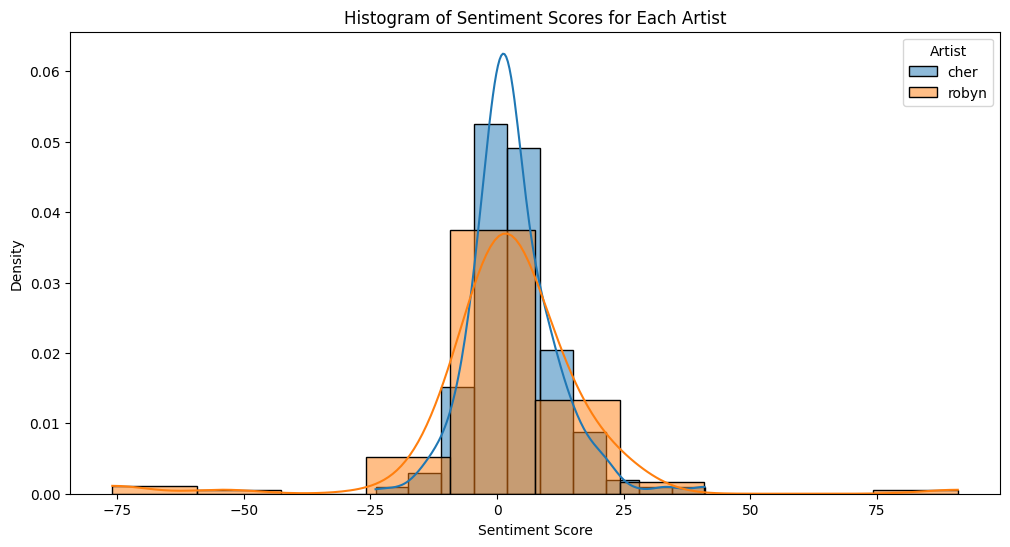

In [55]:
# Plotting histograms for sentiment scores by artist
plt.figure(figsize=(12, 6))

# Create a histogram for each artist
for artist in lyrics_data['artist'].unique():
    subset = lyrics_data[lyrics_data['artist'] == artist]
    sns.histplot(subset['sentiment_score'], bins=10, kde=True, label=artist, stat='density', alpha=0.5)

plt.title('Histogram of Sentiment Scores for Each Artist')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend(title='Artist')
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/).

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [ ]:
# Define positive and negative emojis
positive_emojis = [
    "😀", "😃", "😄", "😁", "😆", "😅", "😂", "🤣", "😊", "😇",
    "🥰", "😍", "🤩", "😘", "😗", "😙", "😚", "🙌", "🎉", "🎊",
    "🎈", "🌈", "🌟", "🌻", "🌼", "🌺", "🍀", "🍎", "🍉", "🍒",
    "💖", "❤️", "💕", "💞", "💗", "💘", "💓", "💝", "💜", "💚",
    "💛", "🧡", "💙", "✨", "🥳", "🤗", "🥂", "🌅"
]

negative_emojis = [
    "😠", "😡", "🤬", "😔", "😟", "😢", "😭", "😱", "😨", "👎",
    "💔", "🖤", "☠️", "💩", "🪦", "⚰️", "🔥", "😩", "😤", "😒",
    "😣", "😖", "😓", "😕", "🤮", "😵", "💀", "😬", "💩"
]

# Create emoji dictionary
emoji_dict = {emoji: 1 for emoji in positive_emojis}
emoji_dict.update({emoji: -1 for emoji in negative_emojis})

In [64]:
# Function to calculate sentiment from emoji
def calculate_emoji_sentiment(description, emoji_dict):
    if pd.isna(description):
        return 0
    score = sum([emoji_dict.get(char, 0) for char in description])
    return score

# Calculate sentiment only for 'cher' and 'robyn'
def calculate_twitter_sentiment_for_selected(twitter_data, emoji_dict, selected_artists):
    twitter_sentiment = {}
    for artist in selected_artists:
        descriptions = twitter_data[twitter_data['artist'] == artist]['description'].tolist()
        total_sentiment = 0
        num_descriptions = len(descriptions)

        for description in descriptions:
            sentiment = calculate_emoji_sentiment(description, emoji_dict)
            total_sentiment += sentiment

        average_sentiment = total_sentiment / num_descriptions if num_descriptions > 0 else 0
        twitter_sentiment[artist] = average_sentiment
    return twitter_sentiment

# Define selected artists
selected_artists = ['cher', 'robyn']

# Calculate sentiment for the selected artists' Twitter descriptions
twitter_sentiment_selected = calculate_twitter_sentiment_for_selected(twitter_data, emoji_dict, selected_artists)

# Output average sentiment scores for each selected artist
for artist, sentiment_score in twitter_sentiment_selected.items():
    print(f"Average emoji sentiment for {artist}: {sentiment_score}")

Average emoji sentiment for cher: 0.05225113729012419
Average emoji sentiment for robyn: 0.03383634882189457


In [74]:
# Function to count emoji occurrences for each artist
def count_emoji_frequencies(descriptions, emoji_dict):
    emoji_counter = Counter()
    for description in descriptions:
        if isinstance(description, str):  # Ensure the description is a string
            for char in description:
                if char in emoji_dict:  # Only emojis in the sentiment dictionary
                    emoji_counter[char] += 1
    return emoji_counter

# Function to find most popular positive and negative emoji
def find_most_popular_emoji(emoji_counts, emoji_dict):
    positive_emoji = max([emoji for emoji in emoji_counts if emoji_dict[emoji] == 1],
                          key=lambda x: emoji_counts[x], default=None)
    negative_emoji = max([emoji for emoji in emoji_counts if emoji_dict[emoji] == -1],
                          key=lambda x: emoji_counts[x], default=None)
    return positive_emoji, negative_emoji

# Function to find and print the most popular emojis for both artists
def print_most_popular_emojis(twitter_data, emoji_dict):
    # Get descriptions for each artist from the DataFrame
    cher_descriptions = twitter_data[twitter_data['artist'] == 'cher']['description'].tolist()
    robyn_descriptions = twitter_data[twitter_data['artist'] == 'robyn']['description'].tolist()

    # Get emoji counts for Cher and Robyn followers
    cher_emoji_counts = count_emoji_frequencies(cher_descriptions, emoji_dict)
    robyn_emoji_counts = count_emoji_frequencies(robyn_descriptions, emoji_dict)

    # Find most popular positive and negative emojis for each artist
    cher_positive_emoji, cher_negative_emoji = find_most_popular_emoji(cher_emoji_counts, emoji_dict)
    robyn_positive_emoji, robyn_negative_emoji = find_most_popular_emoji(robyn_emoji_counts, emoji_dict)

    # Print the results
    print(f"Most popular positive emoji for Cher: {cher_positive_emoji}")
    print(f"Most popular negative emoji for Cher: {cher_negative_emoji}")
    print(f"Most popular positive emoji for Robyn: {robyn_positive_emoji}")
    print(f"Most popular negative emoji for Robyn: {robyn_negative_emoji}")

# Call the function to print results
print_most_popular_emojis(twitter_data, emoji_dict)



Most popular positive emoji for Cher: 🌈
Most popular negative emoji for Cher: 🖤
Most popular positive emoji for Robyn: 🌈
Most popular negative emoji for Robyn: 🖤


Q: What is the average sentiment of your two artists?

A: Cher had an average sentiment of 0.05225 and Robyn had an average sentiment of 0.03383.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji?

A: Based on the output, I am getting that Cher and Robyn both have a rainbow for most popular positive emoji and both have a black heart for the negative emoji. I feel like this is probably incorrect but I tried three different ways to get this tally and I got the same results each time.



References:

Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews."
   Proceedings of the ACM SIGKDD International Conference on Knowledge
   Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle,
   Washington, USA,